## Imports

In [1]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from scipy.stats import norm
import time
from IPython.display import Image as ImageDisp
from sympy import Symbol, symbols, Matrix, sin, cos, latex#, Plot
from sympy.interactive import printing
printing.init_printing()
%pylab inline --no-import-all


Populating the interactive namespace from numpy and matplotlib


## Real Measurements

In [2]:
datafile = '2014-04-23-GNSSGroundTruth.csv'

LatDD, LonDD = np.loadtxt(datafile, delimiter=',', unpack=True, skiprows=1)

print('Read \'%s\' successfully.' % datafile)


Read '2014-04-23-GNSSGroundTruth.csv' successfully.


## Input Parameters

In [3]:
dt    = 1.0/50.0 # Sample Rate of the Measurements is 50Hz
dtGPS = 1.0/10.0 # Sample Rate of GPS is 10Hz
numstates = 7

## Matrices

In [4]:
vs, psis, dpsis, dts, xs, ys, zs, axs, ays, azs, phis, dphis, thetas, dthetas, Lats, Lons = \
 symbols('v \psi \dot\psi T x y z a_x, a_y, a_z, \phi \dot\phi \Theta \dot\Theta Lat Lon')

As = Matrix([[xs+(vs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
             [ys+((vs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))) + ((vs/dthetas)*(sin(thetas+dthetas*dts)-sin(thetas)))],
             [zs+(vs/dthetas)*(-cos(thetas+dthetas*dts)+cos(thetas))],
             [vs + (axs**2 + ays**2 + azs**2)**(1/2)*dts],
             [psis+dpsis*dts],
             [phis+dphis*dts],
             [thetas+dthetas*dts]])
state = Matrix([xs,ys,zs,vs,psis,phis,thetas])

### Dynamic Matrix

In [5]:
As

⎡                           v⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))           
⎢                       x + ───────────────────────────────────────           
⎢                                           \dot\psi                          
⎢                                                                             
⎢    v⋅(cos(\psi) - cos(T⋅\dot\psi + \psi))   v⋅(-sin(\Theta) + sin(T⋅\dot\The
⎢y + ────────────────────────────────────── + ────────────────────────────────
⎢                   \dot\psi                                    \dot\Theta    
⎢                                                                             
⎢                         v⋅(cos(\Theta) - cos(T⋅\dot\Theta + \Theta))        
⎢                     z + ────────────────────────────────────────────        
⎢                                          \dot\Theta                         
⎢                                                                             
⎢                                                   

In [6]:
state

⎡  x   ⎤
⎢      ⎥
⎢  y   ⎥
⎢      ⎥
⎢  z   ⎥
⎢      ⎥
⎢  v   ⎥
⎢      ⎥
⎢ \psi ⎥
⎢      ⎥
⎢ \phi ⎥
⎢      ⎥
⎣\Theta⎦

### Jacobian of the Dynamic Matrix with respect to the state vector

In [7]:
As.jacobian(state)

⎡                              -sin(\psi) + sin(T⋅\dot\psi + \psi)            
⎢1  0  0                       ───────────────────────────────────            
⎢                                            \dot\psi                         
⎢                                                                             
⎢         cos(\psi) - cos(T⋅\dot\psi + \psi)   -sin(\Theta) + sin(T⋅\dot\Theta
⎢0  1  0  ────────────────────────────────── + ───────────────────────────────
⎢                      \dot\psi                                \dot\Theta     
⎢                                                                             
⎢                            cos(\Theta) - cos(T⋅\dot\Theta + \Theta)         
⎢0  0  1                     ────────────────────────────────────────         
⎢                                           \dot\Theta                        
⎢                                                                             
⎢0  0  0                                        1   

### Control Input

In [8]:
control = Matrix([axs, dpsis, dphis, dthetas])
control

⎡    aₓ    ⎤
⎢          ⎥
⎢ \dot\psi ⎥
⎢          ⎥
⎢ \dot\phi ⎥
⎢          ⎥
⎣\dot\Theta⎦

### Jacobian of the Dynamic Matirx with respect to the control input

In [9]:
JGs = As.jacobian(control)
JGs

⎡                                  T⋅v⋅cos(T⋅\dot\psi + \psi)   v⋅(-sin(\psi) 
⎢               0                  ────────────────────────── - ──────────────
⎢                                           \dot\psi                          
⎢                                                                             
⎢                                                                             
⎢                                  T⋅v⋅sin(T⋅\dot\psi + \psi)   v⋅(cos(\psi) -
⎢               0                  ────────────────────────── - ──────────────
⎢                                           \dot\psi                          
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢               0                                                   0         
⎢                                                   

## Read Data

In [10]:
datafile = '2014-04-23-GPS-IMU-Data.csv'

date, \
timem, \
millis, \
ax, \
ay, \
az, \
rollrate, \
pitchrate, \
yawrate, \
roll, \
pitch, \
yaw, \
speed, \
course, \
latitude, \
longitude, \
altitude, \
pdop, \
hdop, \
vdop, \
epe, \
fix, \
satellites_view, \
satellites_used, \
temp = np.loadtxt(datafile, delimiter=',', unpack=True, skiprows=1)

print('Read \'%s\' successfully.' % datafile)

Read '2014-04-23-GPS-IMU-Data.csv' successfully.


In [11]:
print(len(epe))
epe = (np.zeros(epe.shape)+1)*2

6014


## Static Gain

In [12]:
ax = ax + 0.5
ay = ay + 0.5
az = az + 0.5
rollrate = rollrate + 1.42
yawrate = yawrate + 0.07
pitchrate = pitchrate + 2.17

## Process Noise Covariance Matrix Q

In [13]:
jerkmax = 300.0    # m/s3

pitchrateaccmax=  200.0 *np.pi/180.0 # rad/s2
rollrateaccmax =  200.0 *np.pi/180.0 # rad/s2
yawrateaccmax  =  80.0  *np.pi/180.0 # rad/s2

In [14]:
Q = np.diagflat([[(dt * jerkmax)**2],            # acceleration
            [(dt * yawrateaccmax)**2],           # yawrate
            [(dt * pitchrateaccmax)**2],         # pitchrate
            [(dt * rollrateaccmax)**2]])         # rollrate

## Lat/Lon/Alt to Meters

In [36]:
R = 6378388.0 + altitude # m
arc= 2.0*np.pi*R/360.0 # m/°

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m
dz = np.hstack((0.0, np.diff(altitude)))

mx = np.cumsum(dx)
my = np.cumsum(dy)
mz = np.cumsum(dz)

ds = np.sqrt(dx**2+dy**2+dz**2)

GPS=np.hstack((True, (np.diff(ds)>0.0).astype('bool'))) # GPS Trigger for Kalman Filter
print(len(GPS))
print(len(mx))

6014
6014


In [16]:
print('One degree of Lon is %.2fkm at %.1fm altitude.' % (arc[0]/1000.0, altitude[0]))

One degree of Lon is 111.33km at 117.7m altitude.


## Measurement Noise Covariance Matrix R (Adaptive)

In [17]:
state

⎡  x   ⎤
⎢      ⎥
⎢  y   ⎥
⎢      ⎥
⎢  z   ⎥
⎢      ⎥
⎢  v   ⎥
⎢      ⎥
⎢ \psi ⎥
⎢      ⎥
⎢ \phi ⎥
⎢      ⎥
⎣\Theta⎦

In [18]:
R = np.diagflat([[(5.0)**2],      # x
            [(5.0)**2],           # y
            [(5.0)**2],           # z
            [(10.0)**2],  # v
            [(0.5)**2],  # heading 
            [(0.5)**2],  # pitch
            [(0.5)**2]]) # roll

### Position

In [38]:
print(len(ax))
print(len(speed))
epsilon = 0.1
xi      = 500.0
zeta    = 50.0
spspeed=xi/((speed/3.6)+epsilon)

#spspeed=xi/((speed/3.6)+epsilon)
spepe=zeta*epe
sp = (spspeed)**2 + (spepe)**2

6014
6014


### Attitude

In [20]:
rho = 200.0
gamma=500.0

sroll = (rho + gamma*ay)**2
spitch= (rho + gamma*ax)**2
syaw = (rho + gamma*az)**2

## Measurement Function h 

### If GPS measurment is available

In [21]:
hs = Matrix([[xs],[ys],[zs],[vs],[psis],[phis],[thetas]])
Hs=hs.jacobian(state)
Hs

⎡1  0  0  0  0  0  0⎤
⎢                   ⎥
⎢0  1  0  0  0  0  0⎥
⎢                   ⎥
⎢0  0  1  0  0  0  0⎥
⎢                   ⎥
⎢0  0  0  1  0  0  0⎥
⎢                   ⎥
⎢0  0  0  0  1  0  0⎥
⎢                   ⎥
⎢0  0  0  0  0  1  0⎥
⎢                   ⎥
⎣0  0  0  0  0  0  1⎦

### Identity Matrix

In [22]:
I = np.eye(numstates)
print(I, I.shape)

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]] (7, 7)


## Initial State

[[0.        ]
 [0.        ]
 [0.        ]
 [9.46111111]
 [0.        ]
 [0.        ]
 [0.        ]] (7, 1)


/anaconda3/lib/python3.6/site-packages/matplotlib/quiver.py:666: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/anaconda3/lib/python3.6/site-packages/matplotlib/quiver.py:666: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


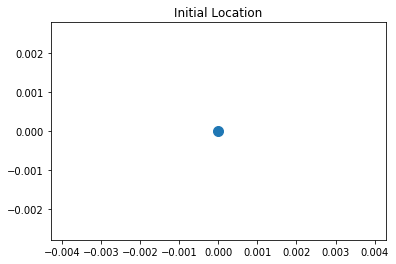

In [23]:
x = np.matrix([[mx[0], my[0], mz[0], speed[0]/3.6, 0.0, 0.0, 0.0]]).T
print(x, x.shape)

U=float(np.cos(x[3])*x[2])
V=float(np.sin(x[3])*x[2])

plt.quiver(x[0], x[1], U, V)
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

## Initial Uncertainty

In [24]:
P = 1e5*np.eye(numstates)

## Measurement Vector

In [25]:
measurements = np.vstack((mx, my, mz, \
                          speed/3.6, \
                          yaw/180.0*np.pi, \
                          pitch/180.0*np.pi, \
                          roll/180.0*np.pi))

# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

(7, 6014)


In [26]:
# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
x7 = []
x8 = []
Zx = []
Zy = []
P0 = []
P1 = []
P2 = []
P3 = []
P4 = []
P5 = []
P6 = []
P7 = []
P8 = []
K0 = []
K1 = []
K2 = []
K3 = []
K4 = []
K5 = []
K6 = []
dstate=[]

## Extended Kalman Filter Step

In [27]:
for filterstep in range(m):

    axc = -ax[filterstep]
    yawc = yawrate[filterstep]/180.0*np.pi
    pitc = pitchrate[filterstep]/180.0*np.pi
    rolc = rollrate[filterstep]/180.0*np.pi
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "Dynamic Matrix"
    if yawc==0.0: # Driving straight
        x[0] = x[0] + x[3]*dt * np.cos(x[4])
        x[1] = x[1] + x[3]*dt * np.sin(x[4])  
        x[2] = x[2] + x[3]*dt * np.cos(x[6])
        x[3] = x[3] + axc*dt
        x[4] = x[4]
        x[5] = x[5] + pitc*dt
        x[6] = x[6] + rolc*dt
        yawc = 0.00000001 # to avoid numerical issues in Jacobians
        dstate.append(0)
    else: # otherwise
        x[0] = x[0] + (x[3]/yawc) * (np.sin(yawc*dt+x[4]) - np.sin(x[4]))
        x[1] = x[1] + ((x[3]/yawc) * (-np.cos(yawc*dt+x[4])+ np.cos(x[4]))) + ((x[2]/rolc) * (np.sin(rolc*dt+x[3])- np.sin(x[3])))
        x[2] = x[2] + ((x[3]/rolc) * (-np.cos(rolc*dt+x[6])+ np.cos(x[6])))
        x[3] = x[3] + axc*dt
        x[4] = (x[4] + yawc*dt + np.pi) % (2.0*np.pi) - np.pi
        x[5] = x[5] + pitc*dt
        #x[6] = x[6] + rolc*dt
        x[6] = (x[6] + rolc*dt + np.pi) % (2.0*np.pi) - np.pi
        dstate.append(1)
    
    
    # Calculate the Jacobian of the Dynamic Matrix A
    # see "Calculate the Jacobian of the Dynamic Matrix with respect to the state vector"
    a14 = float((1.0/yawc) * (np.sin(yawc*dt+x[4]) - np.sin(x[4])))
    a15 = float((x[3]/yawc)* (np.cos(yawc*dt+x[4]) - np.cos(x[4])))
    a24 = float(((1.0/yawc) * (-np.cos(yawc*dt+x[4]) + np.cos(x[4]))) + ((1.0/rolc) * (np.sin(rolc*dt+x[6]) - np.sin(x[6]))))
    a25 = float(x[3]/yawc) * (np.sin(yawc*dt+x[4]) - np.sin(x[4]))
    a27 = float((x[3]/rolc)* (np.cos(rolc*dt+x[6]) - np.cos(x[6])))
    a34 = float((1/rolc)* (-np.cos(rolc*dt+x[6]) + np.cos(x[6])))
    a37 = float((x[3]/rolc)* (np.sin(rolc*dt+x[6]) - np.sin(x[6])))
    JA = np.matrix([[1.0, 0.0, 0.0, a14, a15, 0.0, 0.0],
                  [0.0, 1.0, 0.0, a24, a25, 0.0, a27],
                  [0.0, 0.0, 1.0, a34, 0.0, 0.0, a37],
                  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
    # Calculate the Jacobian of the Control Input G
    # see "Calculate the Jacobian of the Dynamic Matrix with Respect to the Control"
    g12 = float((dt*x[3]/yawc)*np.cos(yawc*dt+x[4]) - x[3]/yawc**2*(np.sin(yawc*dt+x[4])-np.sin(x[4])))
    g22 = float((dt*x[3]/yawc)*np.sin(yawc*dt+x[4]) - x[3]/yawc**2*(-np.cos(yawc*dt+x[4])+np.cos(x[4])))
    g24 = float((dt*x[3]/rolc)*np.cos(rolc*dt+x[6]) - x[3]/rolc**2*(np.sin(rolc*dt+x[6])-np.sin(x[6])))
    g34 = float((dt*x[3]/rolc)*np.sin(rolc*dt+x[6]) - x[3]/rolc**2*(-np.cos(rolc*dt+x[6])+np.cos(x[6])))
    JG = np.matrix([[0.0, g12, 0.0, 0.0],
                    [0.0, g22, 0.0, g24],
                    [0.0, 0.0, 0.0, g34],
                    [dt, 0.0, 0.0, 0.0],
                    [0.0, dt, 0.0, 0.0],
                    [0.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, dt]])
 
    # Project the error covariance ahead
    P = JA*P*JA.T + JG*Q*JG.T
    
    
    # Measurement Update (Correction)
    # ===============================
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[2])],                    
                    [float(x[3])],
                    [float(x[4])],
                    [float(x[5])],
                    [float(x[6])]])
    # Because GPS is sampled with 10Hz and the other Measurements, as well as
    # the filter are sampled with 50Hz, one have to wait for correction until
    # there is a new GPS Measurement
    if GPS[filterstep]:
        # Calculate the Jacobian of the Measurement Function
        # see "Measurement Matrix H"
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    else:
        # Calculate the Jacobian of the Measurement Function
        # see "Measurement Matrix H"
#         JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
        JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
    # Adaptive R
    R[0,0] = sp[filterstep]       # x
    R[1,1] = sp[filterstep]       # y
    R[2,2] = sp[filterstep]
    R[3,3] = spspeed[filterstep]  # v
    R[4,4] = syaw[filterstep]  # course
    R[5,5] = spitch[filterstep]   # pitch
    R[6,6] = sroll[filterstep]    # roll
    

    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    z = measurements[:,filterstep].reshape(JH.shape[0],1)
    y = z - (hx)                         # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*JH))*P
    

    # Save states for Plotting
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    x6.append(float(x[6]))

    P0.append(float(P[0,0]))
    P1.append(float(P[1,1]))
    P2.append(float(P[2,2]))
    P3.append(float(P[3,3]))
    P4.append(float(P[4,4]))
    P5.append(float(P[5,5]))
    P6.append(float(P[6,6]))
    
    #Zx.append(float(z[0]))
    #Zy.append(float(z[1]))    
    
    K0.append(float(K[0,0]))
    K1.append(float(K[1,0]))
    K2.append(float(K[2,0]))
    K3.append(float(K[3,0]))
    K4.append(float(K[4,0]))
    K5.append(float(K[5,0]))
    K6.append(float(K[6,0]))

In [28]:
print(K.shape)

(7, 7)


In [29]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


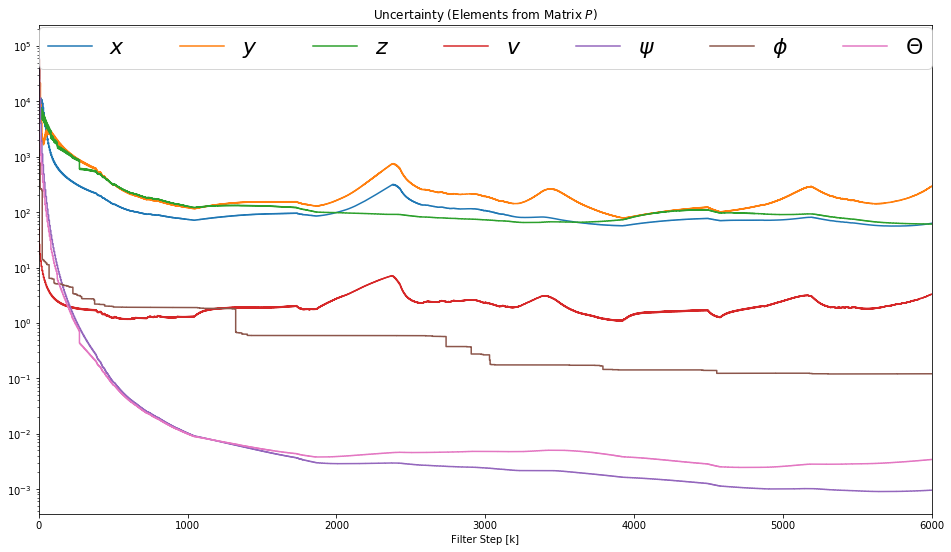

In [30]:
fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),P0, label='$x$')
plt.step(range(m),P1, label='$y$')
plt.step(range(m),P2, label='$z$')
plt.step(range(m),P3, label='$v$')
plt.step(range(m),P4, label='$\psi$')
plt.step(range(m),P5, label='$\phi$')
plt.step(range(m),P6, label='$\Theta$' )

plt.xlabel('Filter Step [k]')
plt.ylabel('')
plt.xlim(0,6000)
plt.title('Uncertainty (Elements from Matrix $P$)')
#plt.legend(loc='best',prop={'size':22})
plt.legend(bbox_to_anchor=(0., 0.91, 1., .06), loc=3,
       ncol=9, mode="expand", borderaxespad=0.,prop={'size':22})
plt.savefig('Covariance-Matrix-Verlauf.eps', bbox_inches='tight')

In [31]:
print(K)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -7.06040266e-09  0.00000000e+00 -4.58300737e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.95794971e-09  0.00000000e+00 -1.51529660e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -7.58559462e-12  0.00000000e+00  3.80972237e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -4.62284407e-12  0.00000000e+00 -3.47880061e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.02895946e-11  0.00000000e+00  3.87165199e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.80403475e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.35809939e-13  0.00000000e+00  5.14969600e-08]]


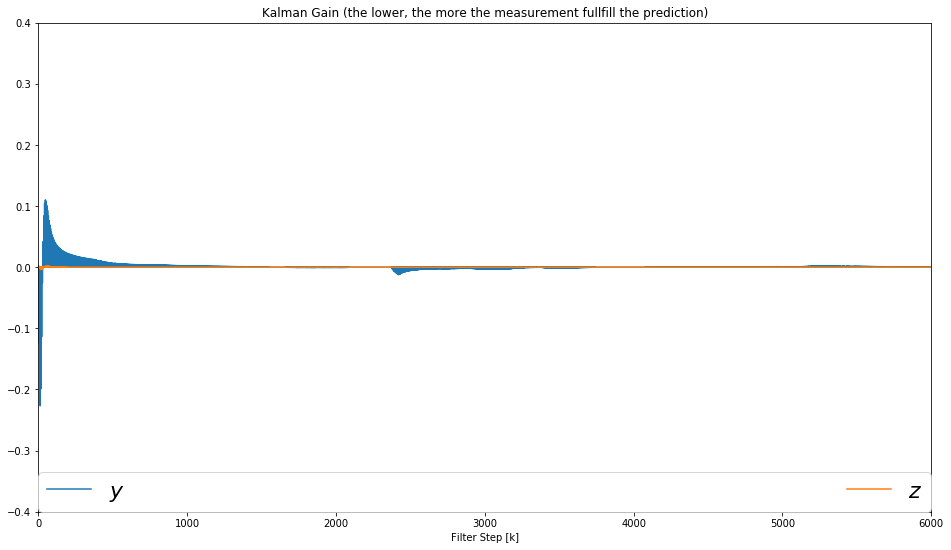

In [32]:
fig = plt.figure(figsize=(16,9))
# plt.step(range(len(measurements[0])),K0, label='$x$')
plt.step(range(len(measurements[0])),K1, label='$y$')
plt.step(range(len(measurements[0])),K2, label='$z$')
# plt.step(range(len(measurements[0])),K3, label='$v$')
# plt.step(range(len(measurements[0])),K4, label='$\dot \psi$')

plt.xlabel('Filter Step [k]')
plt.ylabel('')
plt.xlim(0,6000)
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
#plt.legend(prop={'size':18})
plt.legend(bbox_to_anchor=(0., 0., 1., .102), loc=3,
       ncol=5, mode="expand", borderaxespad=0.,prop={'size':22})
plt.ylim([-0.4,0.4])

In [33]:
latekf = latitude[0] + np.divide(x1,arc)
lonekf = longitude[0]+ np.divide(x0,np.multiply(arc,np.cos(latitude*np.pi/180.0)))
altekf = altitude[0] + x2


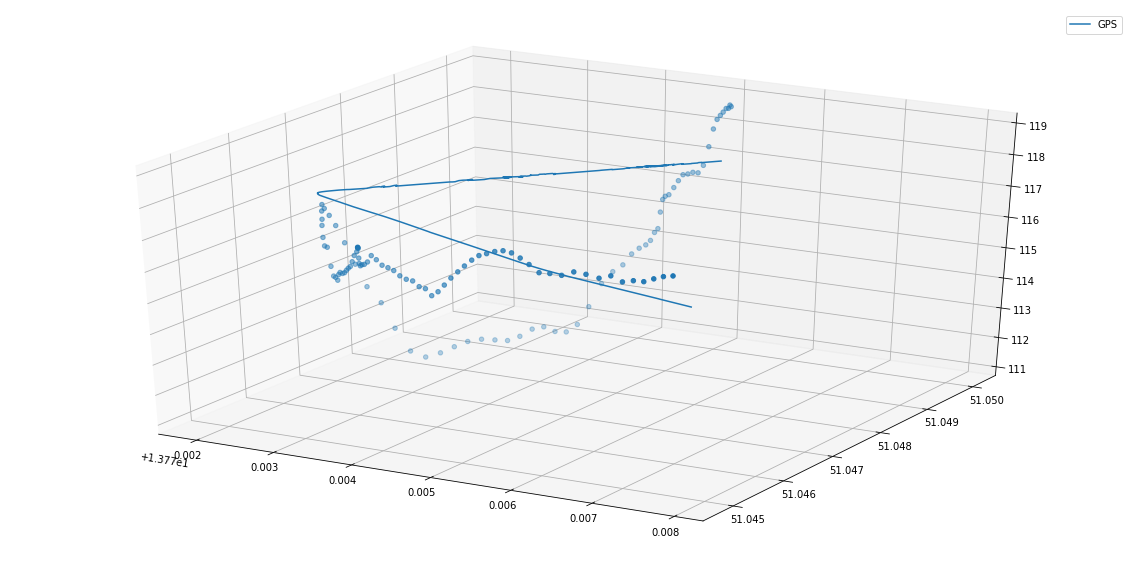

In [34]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# Visualize in 3D 

AltDD = (np.zeros(LatDD.shape)+1)*117
mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure(figsize=(20,10))
axpl = fig.gca(projection='3d')
axpl.plot(LonDD, LatDD, AltDD, label='GPS' )
axpl.scatter(longitude[::50],latitude[::50],altitude[::50])

axpl.legend()

plt.show()

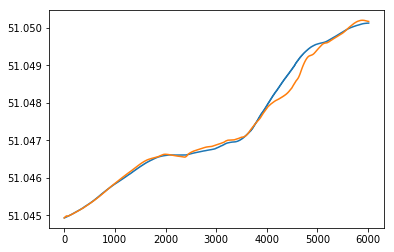

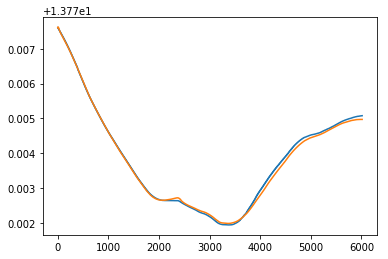

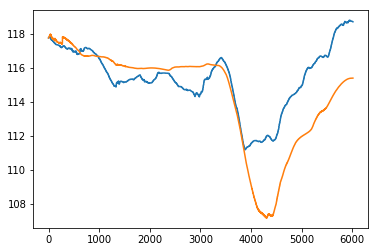

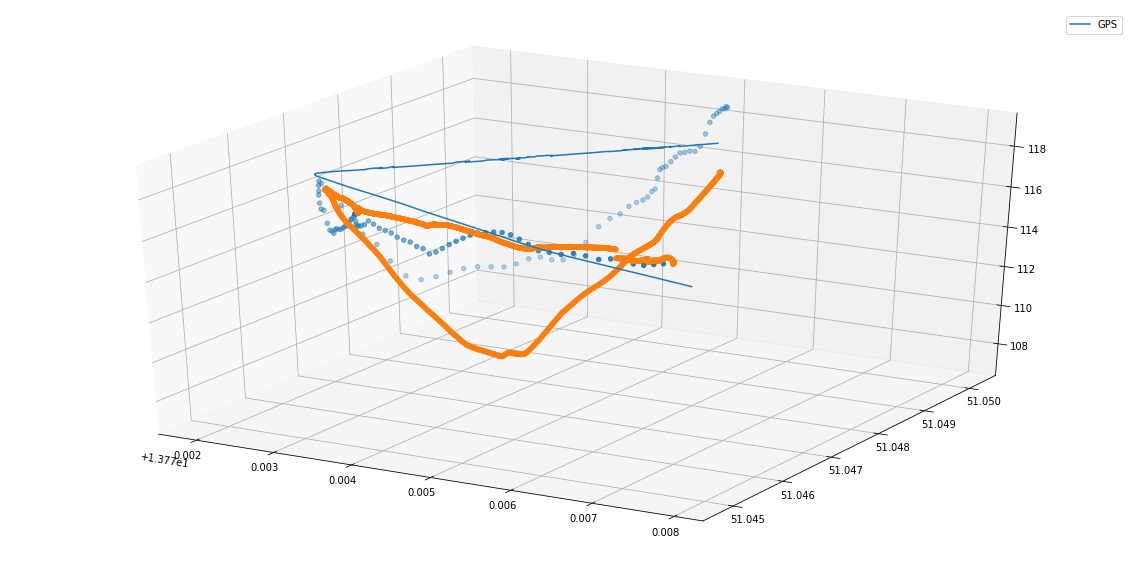

In [35]:
# print(latitude[500:650])
# print(latekf[500:650])

# print(longitude[500:650])
# print(lonekf[50:650])

plt.plot(latitude)
plt.plot(latekf)
plt.show()

plt.plot(longitude)
plt.plot(lonekf)
plt.show()

plt.plot(altitude)
plt.plot(altekf)
plt.show()

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# Visualize in 3D 

AltDD = (np.zeros(LatDD.shape)+1)*117
mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure(figsize=(20,10))
axpl = fig.gca(projection='3d')
axpl.plot(LonDD, LatDD, AltDD, label='GPS' )
axpl.scatter(longitude[::50],latitude[::50],altitude[::50])
axpl.scatter(lonekf, latekf, altekf)
axpl.legend()

plt.show()